In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!unzip "/gdrive/MyDrive/Colab Notebooks/智慧型系統2實驗/data.zip"

Archive:  /gdrive/MyDrive/Colab Notebooks/智慧型系統2實驗/data.zip
   creating: data/
   creating: data/test/
   creating: data/test/cats/
  inflating: data/test/cats/cat.151.jpg  
  inflating: data/test/cats/cat.152.jpg  
  inflating: data/test/cats/cat.153.jpg  
  inflating: data/test/cats/cat.154.jpg  
  inflating: data/test/cats/cat.155.jpg  
  inflating: data/test/cats/cat.156.jpg  
  inflating: data/test/cats/cat.157.jpg  
  inflating: data/test/cats/cat.158.jpg  
  inflating: data/test/cats/cat.159.jpg  
  inflating: data/test/cats/cat.160.jpg  
  inflating: data/test/cats/cat.161.jpg  
  inflating: data/test/cats/cat.162.jpg  
  inflating: data/test/cats/cat.163.jpg  
  inflating: data/test/cats/cat.164.jpg  
  inflating: data/test/cats/cat.165.jpg  
  inflating: data/test/cats/cat.166.jpg  
  inflating: data/test/cats/cat.167.jpg  
  inflating: data/test/cats/cat.168.jpg  
  inflating: data/test/cats/cat.169.jpg  
  inflating: data/test/cats/cat.170.jpg  
  inflating: data/test/cats/

#Import Library
我們載入必要的library：

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from vis.utils import utils
from tensorflow.keras import activations
#from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

# Utility Functions
我們以下會用視覺化的工具來幫助各位了解分類的結果。因此在這邊我們這邊先撰寫幾個utility function。函數的名字應該很好了解其功用，因此建議你可以直接看一下其功能後，就往下一個部分前進。

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    
    acc = history.history['accuracy'][:steps]
    val_acc = history.history['val_accuracy'][:steps]
    loss = history.history['loss'][:steps]
    val_loss = history.history['val_loss'][:steps]
    
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    #plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title("Loss")
    plt.legend()

    
    
    plt.subplot(1,2,2)
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    #plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title("Accuracy")
    plt.legend()

    plt.show()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Data Generator  


In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/content/data/train'
validation_data_dir = '/content/data/validation'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical')

Found 202 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Training a Vanilla Convolutional Neural Network


In [ ]:
# 判斷RGB是在矩陣中的第幾個元素?
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

# Training
因為我們準備的training data和validation data都是利用generator的形式，因此我們在指定輸入資料就直接將輸入資料就直接將train_generator輸入即可

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1)

Epoch 1/10
13/13 [==============================] - 33s 190ms/step - loss: 0.7436 - accuracy: 0.4455 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 2s 162ms/step - loss: 0.6998 - accuracy: 0.4703 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 2s 162ms/step - loss: 0.6944 - accuracy: 0.4802 - val_loss: 0.6870 - val_accuracy: 0.5600
Epoch 4/10
13/13 [==============================] - 2s 162ms/step - loss: 0.6984 - accuracy: 0.5297 - val_loss: 0.6902 - val_accuracy: 0.5200
Epoch 5/10
13/13 [==============================] - 2s 160ms/step - loss: 0.6846 - accuracy: 0.5842 - val_loss: 0.7003 - val_accuracy: 0.5000
Epoch 6/10
13/13 [==============================] - 2s 162ms/step - loss: 0.7230 - accuracy: 0.5842 - val_loss: 0.6627 - val_accuracy: 0.6300
Epoch 7/10
13/13 [==============================] - 2s 160ms/step - loss: 0.7065 - accuracy: 0.6634 - val_loss: 0.6525 - val_accuracy: 0.5900
Epoch

我們可以利用model.save()這個函數，將model存起來供以後使用。

In [ ]:
model.save('vanilla_CNNmodel.h5')
save_history(history, 'vanilla_CNN_history.bin')

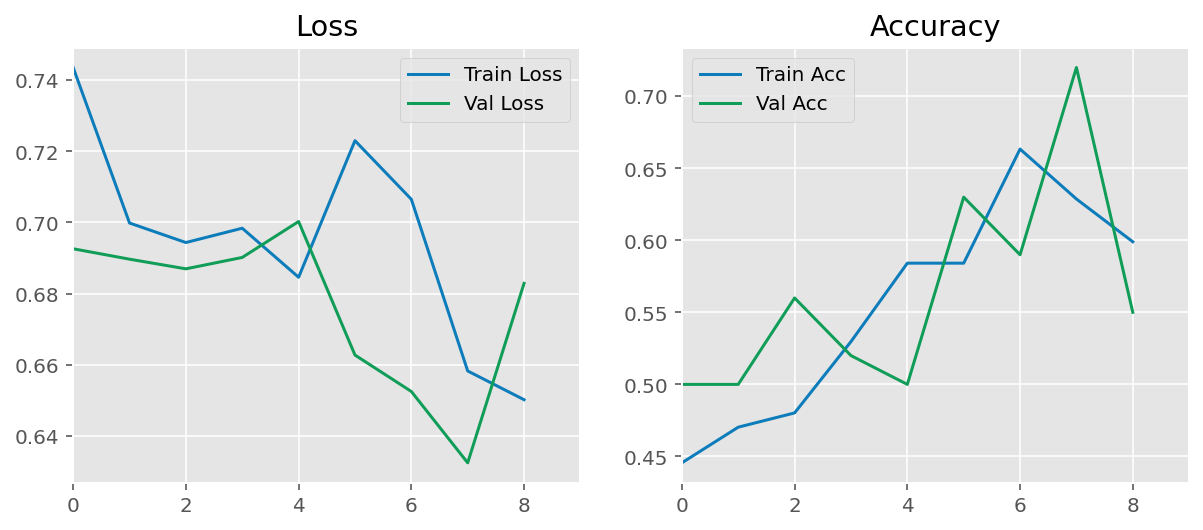

In [ ]:
history = load_history('vanilla_CNN_history.bin')
plot_compare(history)

In [ ]:
!pip install tf-keras-vis

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


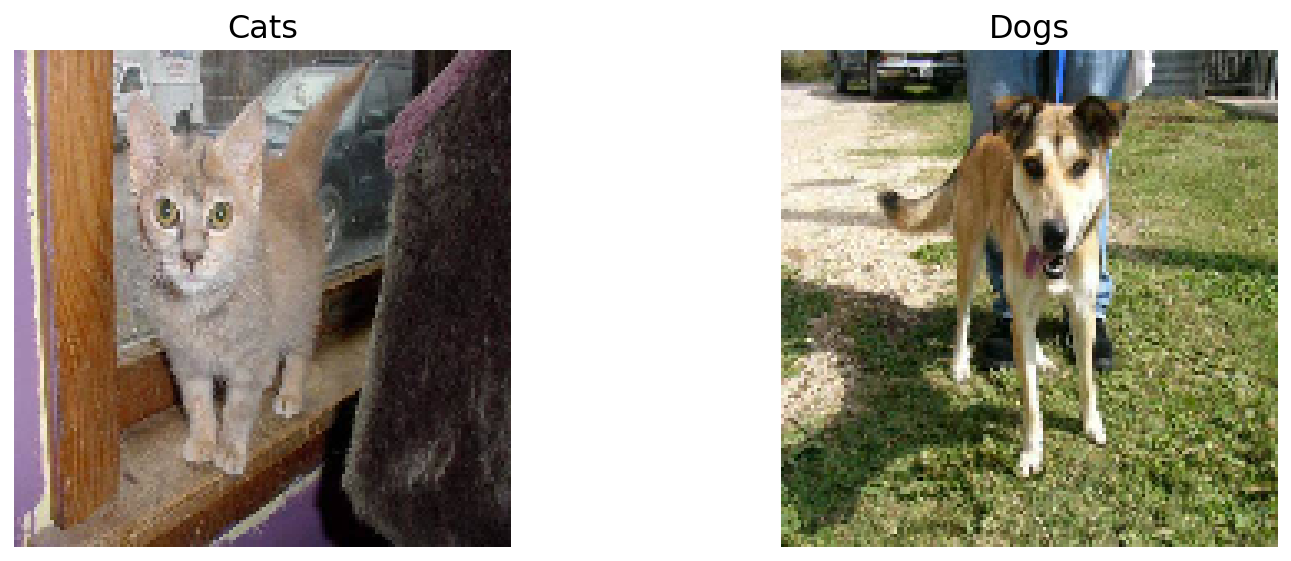

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Cats','Dogs']

# Load images and Convert them to a Numpy array
img1 = load_img('/content/data/test/cats/cat.151.jpg', target_size=(img_width, img_height))
img2 = load_img('/content/data/test/dogs/dog.151.jpg', target_size=(img_width, img_height))
images = np.asarray([np.array(img1), np.array(img2)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0,1])


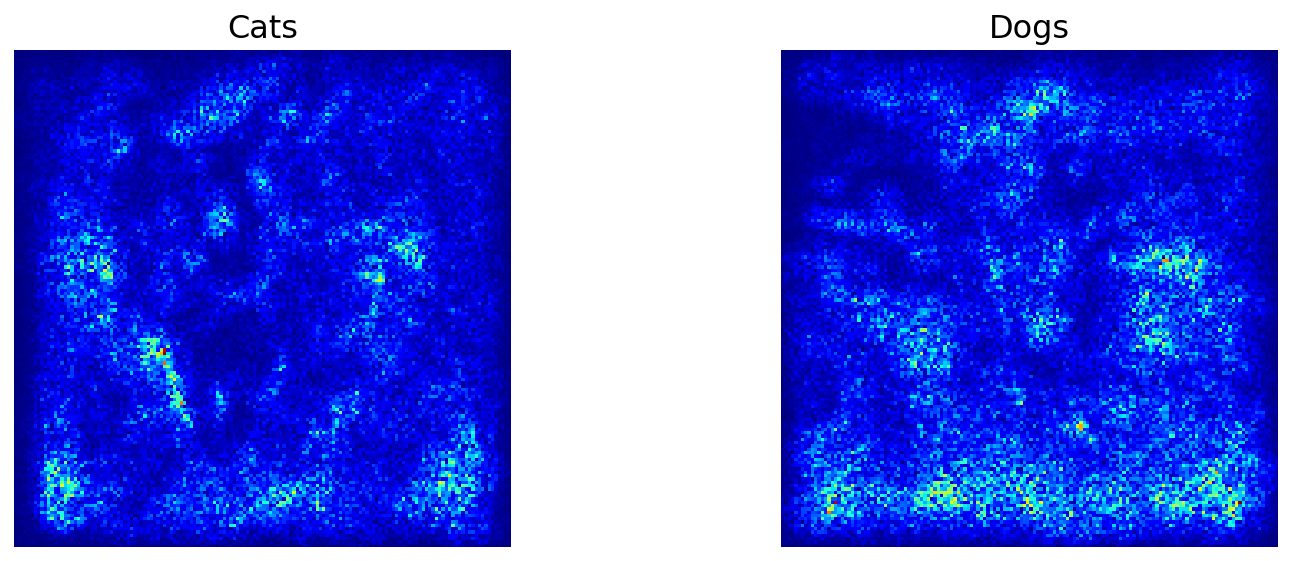

CPU times: user 724 ms, sys: 120 ms, total: 844 ms
Wall time: 734 ms


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

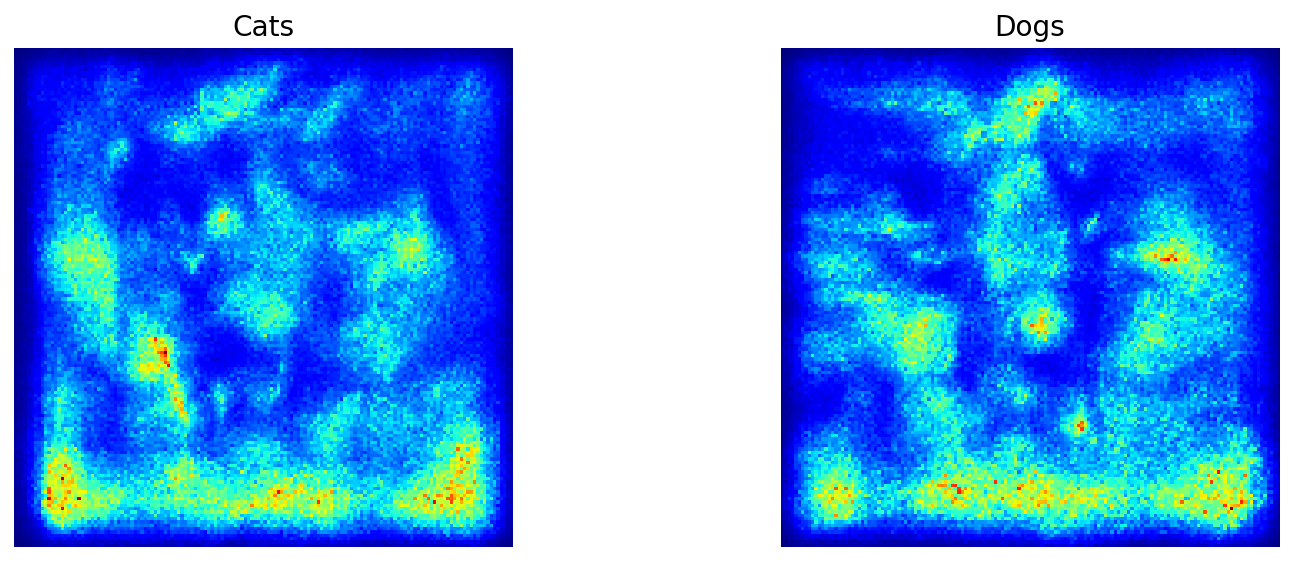

CPU times: user 897 ms, sys: 101 ms, total: 999 ms
Wall time: 933 ms


In [ ]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

(2, 150, 150)


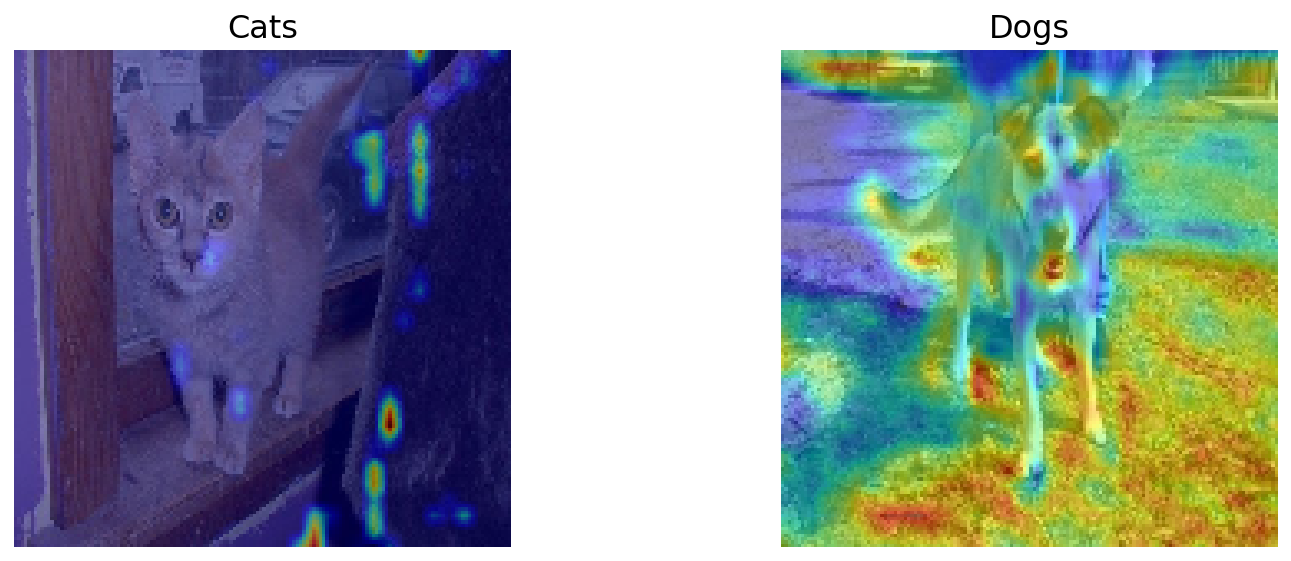

CPU times: user 681 ms, sys: 107 ms, total: 787 ms
Wall time: 694 ms


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)
print(cam.shape)
## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.savefig('GradCAM.png')
plt.tight_layout()
plt.show()

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 5.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=39d5b5a495be14e585c3f0f0e43f50ae44ec640573d489644d0e2c6897438ba3
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Notebook run using keras: 2.6.0


In [ ]:
%%time
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
images = transform_img_fn(["/content/data/test/dogs/dog.151.jpg"])
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 7.61 s, sys: 356 ms, total: 7.97 s
Wall time: 8.46 s


(150, 150, 3)


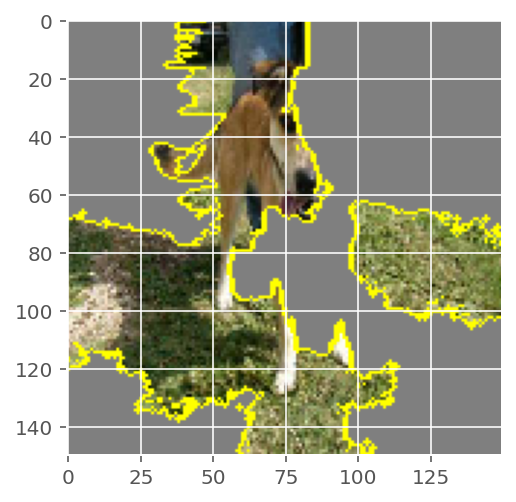

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
print(temp.shape)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("lime_no_positive_onlywithoutrest.jpg")
plt.show()


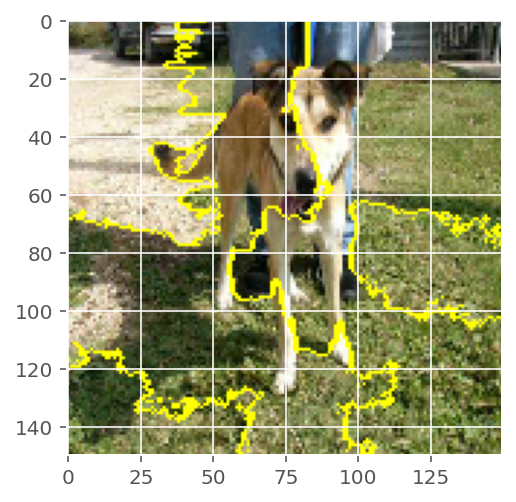

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


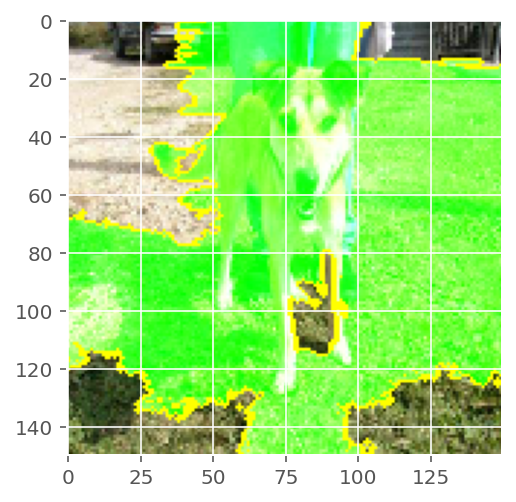

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("lime_no_positive_onlywithrest.jpg")

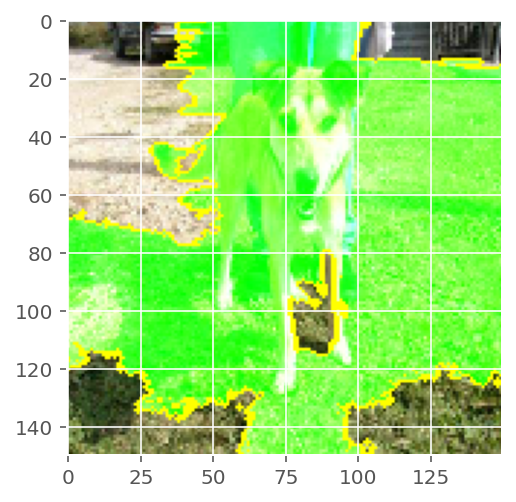

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

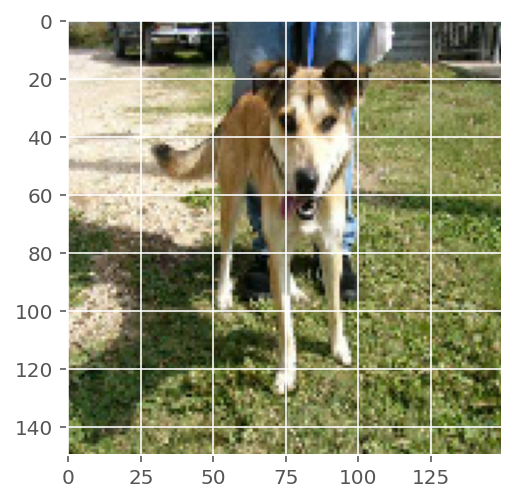

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

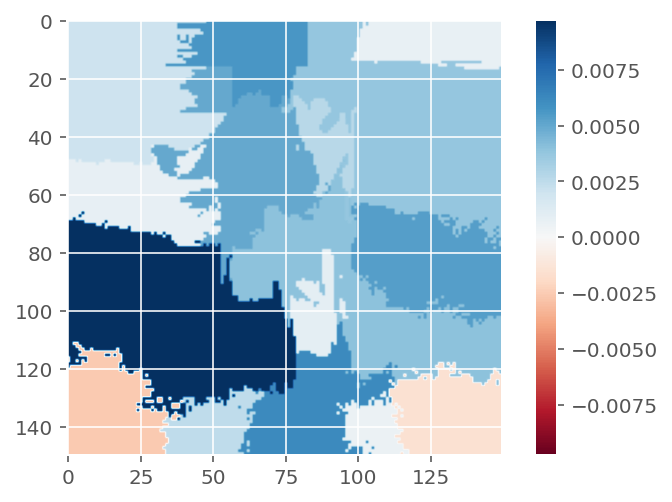

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

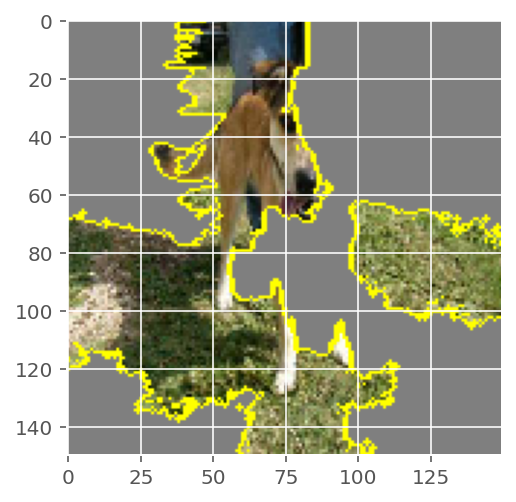

In [ ]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

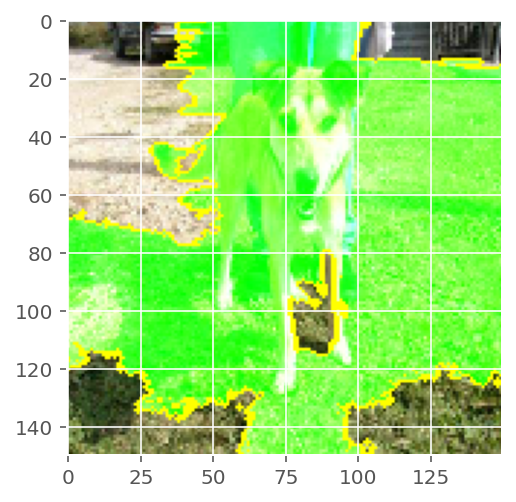

In [ ]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))